# Interpret ageless results

This notebook explores a version of the results based on a model specification that excludes age. It is otherwise exactly like our main model.

We ran ```ageless_gridsearch.Rmd``` three times, producing three different versions of ```ageless_deltas.csv.``` (All uploaded to github.)

The code below averages the three runs, and then pairs the averaged results with a data frame called ```interpret``` that stores the topic categorizes and sizes (the percentage of the corpus in each topic). These are used to produce a weighted average of delta across the corpus.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, linregress
from pathlib import Path

### Load the results of the R scripts.

In [2]:
root = 'ageless_deltas'

deltas = dict()

for i in range(1, 4):
    
    suffix = str(i) + '.csv'
    deltas[i] = pd.read_csv(Path(root + suffix))
    
print(len(deltas), ' files loaded.')

3  files loaded.


There is some continuity but also significant divergence between different runs.

In [3]:
deltas[2].head()

,depvar,cmse,pmse,totalr2,delta,adjdelta,bywidth,fpwidth,bydf,fpdf,pmse_oos,cmse_oos,delta_oos,r2_oos
0,t0,10.195,214.223,0.047553,0.045429,0.124935,by_16,fp_4,8,24,0.074064,1.000000e-08,1.350187e-07,0.026042
1,t1,22.652,18.340,0.015082,0.552596,0.316551,by_16,fp_24,8,3,0.011100,1.510444e-03,1.197790e-01,0.003317
2,t2,45.672,25.625,0.009746,0.640588,0.572054,by_16,fp_16,8,6,0.023348,2.985647e-02,5.611673e-01,-0.004796
3,t3,48.100,265.762,0.138574,0.153252,0.464882,by_20,fp_4,5,24,0.296071,1.690548e-02,5.401522e-02,0.125366
4,t4,93.793,28.723,0.028123,0.765557,0.765557,by_16,fp_12,8,8,0.024392,9.844339e-02,8.014228e-01,0.015066


In [5]:
# How much stability is there between runs?

# Note: I'm using arctanh and tanh to average correlation coefficients
# because r is not normally distributed; it's bounded at 1 and -1, so
# a Fisher's z-transform is needed.

deltalist = []
deltaooslist = []

for i in range(1, 4):
    for j in range(i + 1, 4):
        deltalist.append(spearmanr(deltas[i].delta, deltas[j].delta)[0])
        deltaooslist.append(spearmanr(deltas[i].delta_oos, deltas[j].delta_oos)[0])

def average_rs(rlist):
    r_z = [np.arctanh(x) for x in rlist]
    return np.tanh(np.mean(r_z))
        
print('Avg spearman in-sample: ', average_rs(deltalist))
print('Avg spearman oos: ', average_rs(deltaooslist))


Avg spearman in-sample:  0.810554639711818
Avg spearman oos:  0.8419344293328884


There's more stability between runs than there was with age included, for whatever that's worth.

### Construct a data frame that has average values

In [6]:
smoothed = dict()

cols = ['delta', 'adjdelta', 'delta_oos', 'cmse', 'pmse', 'cmse_oos', 'pmse_oos', 
        'totalr2', 'r2_oos', 'bydf', 'fpdf']

for c in cols:
    if c not in smoothed:
        smoothed[c] = []
    for rownum in range(200):
        values = []
        for i in range(1, 4):
            if c in deltas[i].columns:      # the only exception is 'agemse' which got added late
                                            # and won't be in all five runs
                values.append(deltas[i].loc[rownum, c])
        smoothed[c].append(np.mean(values))

        
avgdf = pd.DataFrame(smoothed)

In [7]:
avgdf.head()

,delta,adjdelta,delta_oos,cmse,pmse,cmse_oos,pmse_oos,totalr2,r2_oos,bydf,fpdf
0,0.042529,0.164976,0.012843,9.715000,219.768000,0.001400,0.081820,0.047467,0.025562,5.666667,24.000000
1,0.628271,0.529399,0.493918,20.696667,12.562667,0.006278,0.006301,0.015458,0.005219,6.000000,4.000000
2,0.666821,0.656717,0.657874,24.701667,13.452000,0.013930,0.010432,0.005746,-0.005031,5.333333,5.000000
3,0.156113,0.415474,0.055135,47.437667,256.783333,0.016668,0.285760,0.136962,0.124828,5.000000,20.000000
4,0.780750,0.698203,0.805778,95.806000,27.089333,0.094896,0.023263,0.027830,0.015612,8.000000,5.666667


In [8]:
# How close are different runs to the average?

for i in range(1, 4):
    print('In sample: ', spearmanr(deltas[i].delta, avgdf.delta)[0])
    print('Out of sample: ', spearmanr(deltas[i].delta_oos, avgdf.delta_oos)[0])

In sample:  0.9316552913822846
Out of sample:  0.9456554960082778
In sample:  0.9359618990474764
Out of sample:  0.9434740868521715
In sample:  0.9306007650191257
Out of sample:  0.9450281257031427


### Load the coding of the 200 topics

In [9]:
interpret = pd.read_csv('../interrater/k200standardcoding.tsv', sep = '\t')
interpret.drop(columns = ['next5books, biggestauth, datequartiles', 'comments'], inplace = True)
interpret.head()

,topicstats,keywords,top7books,label,category
0,TOPIC 0 pct corpus = 0.267% doc entropy = 9.80...,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","war, mostly WWII",event
1,TOPIC 1 pct corpus = 0.288% doc entropy = 9.74...,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","e20c scientists, labs, and professors, mostly ...",genre
2,TOPIC 2 pct corpus = 0.479% doc entropy = 10.4...,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","objects in relation to doors, pockets, rooms, ...",physical description
3,TOPIC 3 pct corpus = 0.388% doc entropy = 9.34...,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...",late 20c US political thrillers,genre
4,TOPIC 4 pct corpus = 0.666% doc entropy = 10.3...,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...",diffuse,uncategorized dimension of style


For our present purposes, we don't need all this information, and we could use shorter category labels for visualization.

In [10]:
# FUNCTIONS THAT SIMPLIFY AND CLEAN THE CODING FRAME

def getpct(astring):
    firstpart = astring.split('%')[0]
    number = float(firstpart.split('= ')[1])
    return number

def shorten(astring):
    shortversion = astring[0:6]
    if shortversion == 'human ':
        shortversion = 'institu' # for human institution, practice, or relationship
    return shortversion

interpret['pct'] = interpret.topicstats.map(getpct)
interpret['category'] = interpret.category.map(shorten)
interpret.drop(columns = ['keywords', 'top7books', 'topicstats'], inplace = True)
interpret.head()

,label,category,pct
0,"war, mostly WWII",event,0.267
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288
2,"objects in relation to doors, pockets, rooms, ...",physic,0.479
3,late 20c US political thrillers,genre,0.388
4,diffuse,uncate,0.666


### Concatenate the topic labels with all three frames of numeric results.

In [11]:
topics = dict()
for i in range(1, 4):
    topics[i] = pd.concat([deltas[i], interpret], axis = 1)

### And also with the average of all five.

In [12]:
avgdf = pd.concat([avgdf, interpret], axis = 1)

In [13]:
def weighted_avg(aframe):
    avg = sum(aframe.pct * aframe.cmse) / (sum(aframe.pct * aframe.cmse) + sum(aframe.pct * aframe.pmse))
    return avg

def weighted_avg_oos(aframe):
    cmseoos = [0 if i < 0 else i for i in aframe.cmse_oos]
    pmseoos = [0 if i < 0 else i for i in aframe.pmse_oos]  
    avg = sum(aframe.pct * cmseoos) / (sum(aframe.pct * cmseoos) + sum(aframe.pct * pmseoos))
    return avg

### Calculate average delta as per our pre-registered plan.

The columns that matter most are the "weighted" ones; we've already decided to care more about variables where the model is strong than about ones where r2 is low and no chronological variables are very predictive--also more about large topics than small ones.

In [14]:
print('raw in-sample\traw oos\t\tweighted in-sample\tweighted oos')
for i in range(1, 4):
    print(round(np.mean(topics[i].delta), 4), '\t\t', round(np.mean(topics[i].delta_oos), 4), '\t\t',
          round(weighted_avg(topics[i]), 4), '\t\t', round(weighted_avg_oos(topics[i]), 4))

raw in-sample	raw oos		weighted in-sample	weighted oos
0.5666 		 0.5208 		 0.5525 		 0.5239
0.5637 		 0.5272 		 0.5667 		 0.5359
0.5608 		 0.5293 		 0.5684 		 0.5322


In [17]:
print("Overall, weighted in-sample is", round(weighted_avg(avgdf), 4))
print("And out-of-sample: ", round(weighted_avg_oos(avgdf), 4))

Overall, weighted in-sample is 0.5626
And out-of-sample:  0.5307


Actually, technically we proposed to exclude 'accidents of transcription' and 'author-dominated' categories from the average. This makes only a small difference.

In [20]:
legit = avgdf.loc[(avgdf.category != 'accide') & (avgdf.category != 'author'), :]
print("Overall, weighted in-sample is", round(weighted_avg(legit), 4))
print("And out-of-sample: ", round(weighted_avg_oos(legit), 4))

Overall, weighted in-sample is 0.5647
And out-of-sample:  0.532


### Differences between topic categories

Our article focuses on the way r2 is partitioned by ANOVA (in-sample). In theory there are advantages to calculating on out-of-sample data, but I suspect in practice it's noisier, as seen by the low Spearman correlations in cells above.

Here are category means (not weighted by topic size or r2):

In [23]:
cats = avgdf.category.unique()
deltadict = dict()
for c in cats:
    deltadict[c] = avgdf.loc[avgdf.category == c, 'delta'].tolist()
    print(c, np.mean(deltadict[c]))

event 0.37362084098388026
genre 0.5270471099095028
physic 0.6240322925421903
uncate 0.5097891398793237
techno 0.5735259812475734
institu 0.6071104398176553
dialec 0.5567305130642582
nation 0.6305065498366309
author 0.6264701035500777
accide 0.5188935045660072


And a visualization.

In [24]:
def widen (astring):
    mapper = {'event': 'event  ', 'genre': 'genre  ', 'dialec': 'dialect or language  ', 'accide': 'accident of transcription  ', 'author': 'author-dominated topic  ',  
              'techno': 'technological change  ', 'uncate': 'uncategorized  ', 'institu': 'institution or practice  ', 'nation': 'nationality or region  ', 
              'physic': 'physical description  '}
    return mapper[astring]

avgdf['longcategory'] = avgdf.category.map(widen)

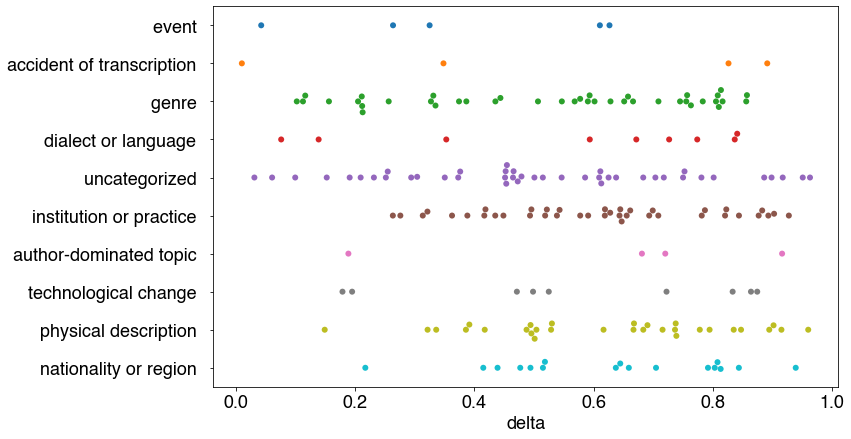

In [26]:
plt.rcParams.update({'font.sans-serif':'Helvetica'})
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (11.2, 7))
res = sns.swarmplot(data = avgdf, x = 'delta', y = 'longcategory', order = ['event  ', 'accident of transcription  ', 'genre  ',
                                                                            'dialect or language  ', 'uncategorized  ',   
                                                                   'institution or practice  ',
                                                                     'author-dominated topic  ', 'technological change  ',
                                                                    'physical description  ', 'nationality or region  '], orient = 'h', size = 6)
plt.ylabel('')
plt.gcf().set_facecolor('white')
# plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/swarmdeltashelvetica.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [38]:
avgdf.loc[avgdf.category == 'event', : ]

,delta,adjdelta,delta_oos,cmse,pmse,cmse_oos,pmse_oos,totalr2,r2_oos,bydf,fpdf,agemse,label,category,pct,longcategory
0,0.052664,0.185230,0.078345,11.6860,209.5212,0.020000,0.102817,0.047869,0.024379,6.2,24.0,0.53325,"war, mostly WWII",event,0.267,event
63,0.269352,0.395927,0.023510,10.7786,29.9736,0.000621,0.023230,0.012020,-0.003758,4.8,9.6,0.30050,revolutionary and communist movements,event,0.348,event
86,0.555281,0.565166,0.478879,42.1664,34.0802,0.017909,0.022856,0.018071,0.002273,6.2,7.2,0.61975,"warfare, probably centered on WWI",event,0.212,event
110,0.396742,0.412263,0.437117,19.9406,30.8042,0.035048,0.060875,0.018361,0.009139,4.2,5.0,14.68125,war,event,0.290,event
145,0.455780,0.446869,0.398534,38.5564,24.9040,0.041446,0.021034,0.020356,0.003584,9.0,7.8,1.32425,"warfare, probably centered on WWI",event,0.349,event


This pattern holds just as strongly if we measure delta out of sample.

In [27]:
deltadict = dict()
for c in cats:
    deltadict[c] = avgdf.loc[avgdf.category == c, 'delta_oos'].tolist()
    print(c, np.mean(deltadict[c]))

event 0.3143675683336139
genre 0.4846685704481592
physic 0.5878322858645365
uncate 0.4803052173423168
techno 0.48608934582754404
institu 0.6097034073441273
dialec 0.5315055462925622
nation 0.5337666120150583
author 0.5685054061450621
accide 0.40653410268424806


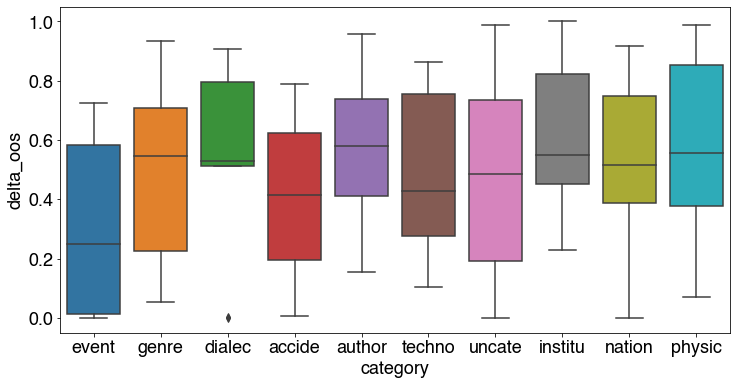

In [28]:
plt.figure(figsize = (12, 6))
sns.boxplot(data = avgdf, x = 'category', y = 'delta_oos', order = ['event', 'genre','dialec', 'accide', 'author',  'techno', 'uncate',  
                                                                  'institu', 'nation', 'physic'])
plt.rcParams.update({'font.size': 10})
plt.show()

### Testing our pre-registered hypothesis about categories

We specified that we didn't expect *p* < .05 kind of significance here, because n is very low (n for the three categories is 5, 4, and 9)!

Instead we were going to look at effect size. For instance, Cohen's *d*. And any way you measure this (in or out of sample), there is in fact a non-trivial effect.

But this is mostly the ```event``` (and to some extent ```accident```) topics pulling down the ```technology``` category. If we just considered the technology topics by themselves, they wouldn't seem notably divergent from the rest of the model.

So our hypothesis is confirmed, but with some internal variation that shows we're not seeing exactly what we might have expected.

In [29]:
target_cat_deltas = avgdf.loc[(avgdf.category == 'event') | (avgdf.category == 'accide') | (avgdf.category == 'techno'), 'delta']
np.mean(target_cat_deltas)

0.5058562252450883

In [30]:
other_deltas = avgdf.loc[(avgdf.category != 'event') & (avgdf.category != 'accide') & (avgdf.category != 'techno'), 'delta']
np.mean(other_deltas)

0.569429449007399

In [31]:
## Calculate Cohen's d.

(np.mean(other_deltas) - np.mean(target_cat_deltas)) / np.std(avgdf.delta)

0.27057267788724754

### Where is r2 strong?

This is a bit of a surprise. "Genre" and "physical description" are the categories where chronological variables have most explanatory power.

I might have expected ```technology``` and ```event``` to have higher r2s.

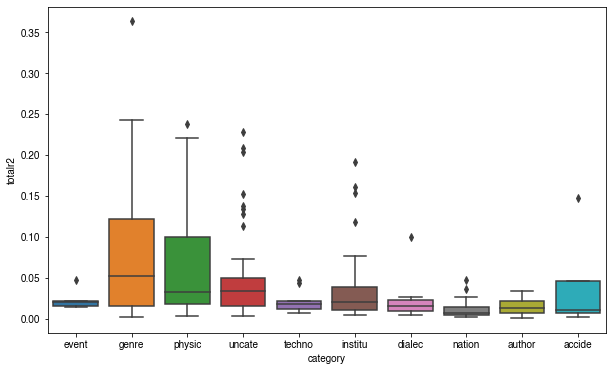

In [32]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = avgdf, x = 'category', y = 'totalr2')
plt.show()

### Calculate average r2 weighted by topic size

In [33]:
weightedavgr2 = np.average(avgdf.totalr2, weights = avgdf.pct)
print('r2: ', weightedavgr2)

r2:  0.05968518052016002


R2 is just a little smaller.

In [46]:
naiver2 = np.mean(avgdf.totalr2)
naiver2

0.04824305555910859

In [47]:
pearsonr(avgdf.totalr2, avgdf.delta)

(-0.13701026594934354, 0.05303869605258556)

In [30]:
pearsonr(avgdf.totalr2, avgdf.pct)

(0.3152599825163253, 5.441744444581996e-06)

So, there's a significant and moderately strong pattern that r2 is larger when a topic contains more words. Not very surprising.

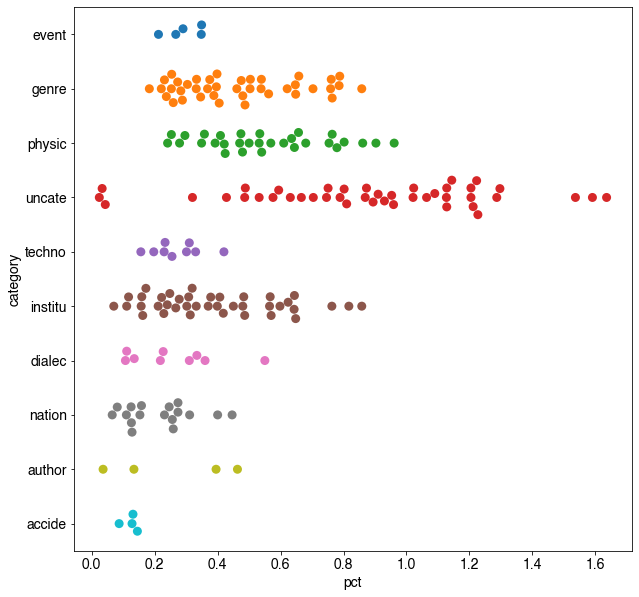

In [48]:
plt.rcParams.update({'font.sans-serif':'Helvetica'})
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (10, 10))
sns.swarmplot(data = avgdf, y = 'category', x = 'pct', orient = 'h', size = 9)
plt.show()

Categories are quite strongly grouped, but this is not altogether surprising since r2 correlates with topic size and topic size is one of the things we looked at in categorizing.

### Examine particular topics to understand patterns better

Let's look at the trajectories of topics over time to understand why they are associated with period or cohort.

In [49]:
bookdata = pd.read_csv('../topicdata/bookleveltopicdata.tsv', sep = '\t', low_memory = False) 

In [50]:
data = bookdata.loc[bookdata.us_national & (bookdata.firstpub > 1889) & (bookdata.firstpub < 1990), : ]
data.shape

(5572, 208)

In [51]:
def extract_trajectories(depvar, data):
    avgbyfirstpub = []
    avgbybirthyear = []
    firstpubtimeline = []
    birthyeartimeline = []
    for fp, df in data.groupby('firstpub'):
        if fp > 1889 and fp < 1990:
            firstpubtimeline.append(fp)
            avgbyfirstpub.append(np.mean(df[depvar]))
            
    for by, df in data.groupby('birthyear'):
        if by > 1850 and by < 1960:
            birthyeartimeline.append(by)
            avgbybirthyear.append(np.mean(df[depvar]))
    
    return firstpubtimeline, avgbyfirstpub, birthyeartimeline, avgbybirthyear

In [52]:
fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t0', data)

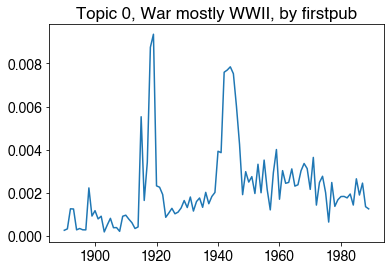

In [53]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 0, War mostly WWII, by firstpub')
plt.show()

You can see why models of that trajectory invariably choose a 4-year granularity. It's very tightly responsive to events.

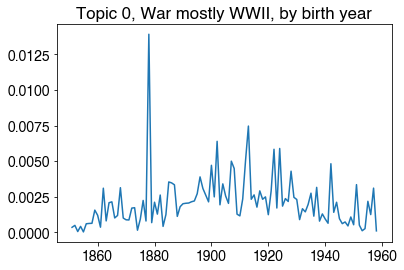

In [54]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 0, War mostly WWII, by birth year')
plt.show()

Although there is one crazy spike there, models of birthyear choose a 16-year granularity on average, because it's a smoother pattern on the whole.

In [55]:
fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t141', data)

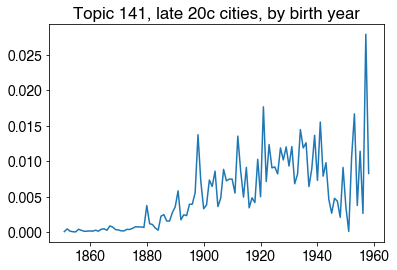

In [56]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 141, late 20c cities, by birth year')
plt.show()

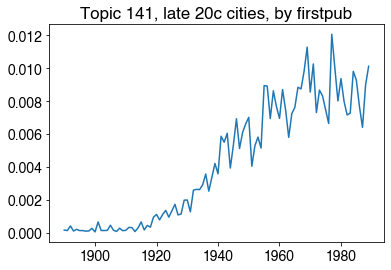

In [57]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 141, late 20c cities, by firstpub')
plt.show()

In [58]:
x = []
y = []
variable = []
topicnumber = []

for tn in ['t0', 't141']:
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories(tn, data)
    if tn == 't0':
        topicname = "War"
    else:
        topicname = "Urban life"
        
    x.extend(fpxaxis)
    y.extend(avgbyfirstpub)
    variable.extend(['pub. year'] * len(fpxaxis))
    topicnumber.extend([topicname] * len(fpxaxis))
    
    x.extend(byxaxis)
    y.extend(avgbybirthyear)
    variable.extend(["birth year"] * len(byxaxis))
    topicnumber.extend([topicname] * len(byxaxis))

facetdf = pd.DataFrame({'year': x, 'prominence': y, 'x': variable, 'topic': topicnumber})

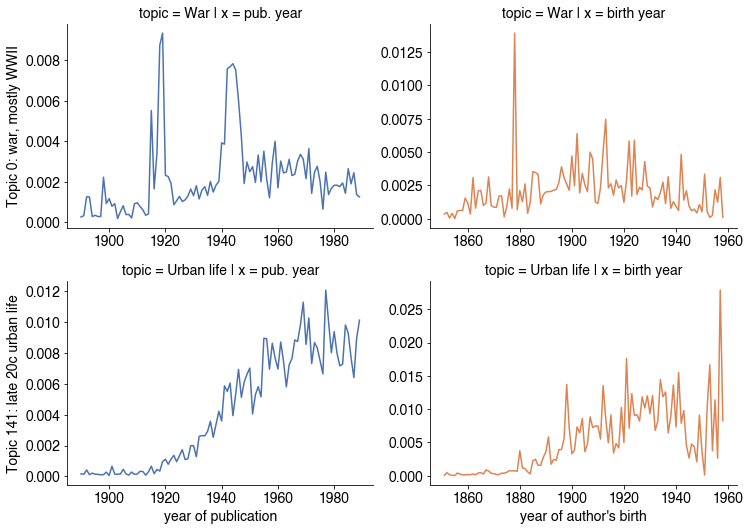

In [68]:
plt.rcParams.update({'font.sans-serif':'Helvetica'})
plt.rcParams.update({'font.size': 14})
# plt.figure(figsize = (11.2, 9))
g = sns.FacetGrid(facetdf, row = 'topic', col = 'x', hue = 'x', height = 3.8, aspect = 1.4, 
                  sharex = False, sharey = False, palette = 'deep')
g.map(sns.lineplot, 'year', 'prominence')

g.axes[1,0].set_xlabel('year of publication')
g.axes[1,1].set_xlabel("year of author's birth")
g.axes[1,0].set_ylabel("Topic 141: late 20c urban life")
g.axes[0,0].set_ylabel('Topic 0: war, mostly WWII')
plt.gcf().set_facecolor('white')
plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/lineplothelvetica.png', bbox_inches = 'tight', dpi = 300)

### A slope hypothesis producing null results

Patterns like the one below give us some reason to think that period-driven changes cause steep upslopes, whereas cohorts become more determinative when topics are in decline. (Writers "hold onto the practices they learned in youth.")

This seems to be true of crime fiction.

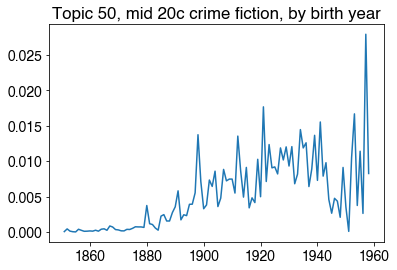

In [60]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 50, mid 20c crime fiction, by birth year')
plt.show()

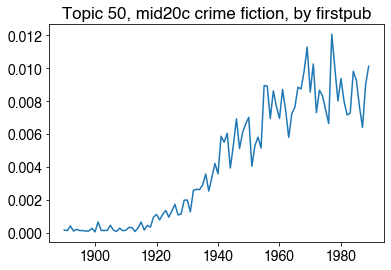

In [61]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 50, mid20c crime fiction, by firstpub')
plt.show()

It's also supported by a pattern we find in the "technology" category. Generally speaking, emergent technologies, with a positive slope, are more period-driven than residual technologies, with a net negative slope across the century.

In [62]:
techno = avgdf.loc[avgdf.category == 'techno', : ].copy()
techno.sort_values(by = 'delta', inplace = True)

slopes = []

for idx, row in techno.iterrows():
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t' + str(idx), data)
    slope_0, intercept, r_value, p_value, std_err = linregress(fpxaxis, avgbyfirstpub)
    slopes.append(slope_0)

techno = techno.assign(slope = slopes)

techno.loc[ : , ['delta', 'slope', 'totalr2', 'bydf', 'fpdf', 'label']]

,delta,slope,totalr2,bydf,fpdf,label
164,0.119125,0.000043,0.042852,5.0,8.8,automobiles
22,0.223877,-0.000058,0.048069,5.4,5.8,e20c rail travel
122,0.462933,0.000047,0.023809,7.2,8.2,aeronautics
36,0.465517,0.000037,0.017820,6.4,5.4,late 20c hospitals
11,0.555884,-0.000025,0.012866,9.2,5.6,e20c industrial work
8,0.772940,-0.000004,0.012472,9.8,7.6,e20c medicine
134,0.775382,-0.000031,0.007277,4.8,5.2,boats and nautical matters
104,0.861139,-0.000012,0.010130,5.0,4.8,sea travel (and perhaps also colonialism?)
23,0.936870,-0.000031,0.018271,7.2,3.2,horse-drawn modes of transportation


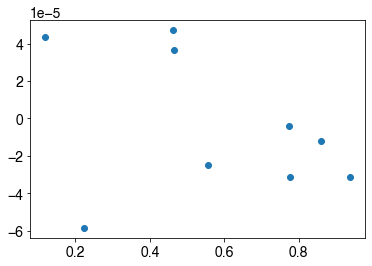

In [63]:
plt.scatter(techno.delta, techno.slope)

However we don't find a lot of evidence that this is true across all 200 topics.

In [64]:
slopes = []

for topnum in range(200):
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t' + str(topnum), data)
    slope_0, intercept, r_value, p_value, std_err = linregress(fpxaxis, avgbyfirstpub)
    # r2, p = spearmanr(byxaxis, avgbybirthyear)
    slopes.append(slope_0)

slopes = np.array(slopes)

In [65]:
pearsonr(slopes, avgdf.delta)

(-0.068023931869791, 0.33852541193795055)

### Comparison to the SEM experiment

How do the results of structural equation modeling compare to the deltas we inferred from our regression experiment?

First we load the SEM results.

In [49]:
sem = pd.read_csv('../sem-topics/sem_topic_preferred.csv')
sem

,topic,mod_spec,BIC,chisq,npar,rmsea,converged,nobs,type,BIC_diff,verdict
0,t0,SDM2,56969.193690,1.958359,4,0.000000,True,6927,SDM,-7.037195,SDM
1,t1,SDM2,48125.223978,8.597923,4,0.021823,True,6927,SDM,-1.259729,Inconclusive
2,t2,AUM4,55315.111779,0.168859,5,0.000000,True,6927,AUM,-55.808567,AUM
3,t3,AUM4,55520.822670,29.295657,5,0.063913,True,6927,AUM,-165.653195,AUM
4,t4,AUM4,54385.747324,0.864300,5,0.000000,True,6927,AUM,-4.858876,AUM
...,...,...,...,...,...,...,...,...,...,...,...
195,t195,AUM4,54113.247327,262.560467,5,0.194318,True,6927,AUM,-106.085575,AUM
196,t196,AUM4,56859.515032,0.917575,5,0.000000,True,6927,AUM,-72.102139,AUM
197,t197,AUM4,59206.695610,248.831882,5,0.189150,True,6927,AUM,-85.240279,AUM
198,t198,AUM4,54100.603634,13.319917,5,0.042173,True,6927,AUM,-286.891595,AUM


Then we separate two categories of topics: those where the active updating model was preferred, and those where the settled disposition model was preferred.

In [50]:
aumdeltas = avgdf.loc[sem.verdict == 'AUM', 'delta']

In [51]:
sdmdeltas = avgdf.loc[sem.verdict == 'SDM', 'delta']

A naive approach would be to directly calculate the difference between these deltas by taking the means and using a t-test to evaluate the difference of means.

In [52]:
print('AUM: ', round(np.mean(aumdeltas), 4))
print('SDM: ', round(np.mean(sdmdeltas), 4))

AUM:  0.5283
SDM:  0.5956


In [53]:
ttest_ind(aumdeltas, sdmdeltas, equal_var = False) # Welch's t-test

Ttest_indResult(statistic=-2.063384036127074, pvalue=0.041240118896226474)

The difference would be significant, if we took that naive approach.

#### A better approach

However, recall that in reality we weight deltas both by $r^2$ and by the size of the topic when calculating overall delta. It's reasonable to apply the same weights to calculate the means of the two groups here, and apply them also to the t-test.

In [54]:
avgdf = avgdf.assign(weights = avgdf.pct * avgdf.totalr2)
avgdf = avgdf.assign(weights = avgdf.weights * (200 / sum(avgdf.weights)))

In [55]:
aumpct = avgdf.loc[sem.verdict == 'AUM', 'pct']
sdmpct = avgdf.loc[sem.verdict == 'SDM', 'pct']

In [56]:
aumr2 = avgdf.loc[sem.verdict == 'AUM', 'totalr2']
sdmr2 = avgdf.loc[sem.verdict == 'SDM', 'totalr2']
aumweights = aumpct * aumr2
sdmweights = sdmpct * sdmr2

In [57]:
allweights = np.concatenate([aumweights, sdmweights])
allweights = allweights * (len(allweights) / sum(allweights))
print(sum(allweights))

185.0000000000002


That's a sanity check; the numbers should add up to the length of the vectors.

In [58]:
aumweights = allweights[0 : len(aumweights)]
sdmweights = allweights[len(aumweights) : ]

In [59]:
from statsmodels.stats.weightstats import ttest_ind     # a more flexible implementation

In [60]:
ttest_ind(x1 = aumdeltas, x2 = sdmdeltas, weights = (aumweights, sdmweights), usevar = 'unequal')  # returns t statistic, pval, dfs

(-4.010727349462678, 0.0001524849609534686, 68.29695788078511)

In [61]:
np.average(aumdeltas, weights = aumweights)

0.49556172553283845

In [62]:
np.average(sdmdeltas, weights = sdmweights)

0.6448849511590758

Those are the means and statistics we report in the article.

In [63]:
sum((sem.verdict == 'AUM') & (avgdf.delta > 0.5))     # I quote this figure at one point

69

#### visualizing the difference of means described above

In [64]:
avgdf['semtype'] = sem.verdict.values

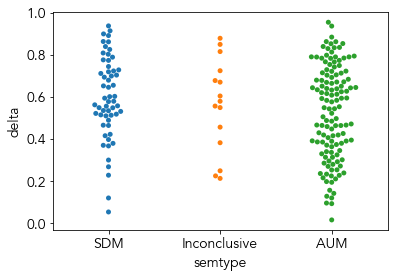

In [65]:
sns.swarmplot(data = avgdf, x = 'semtype', y = 'delta')
plt.show()

In [68]:
summary = pd.read_csv('../topic_summary.tsv', sep = '\t')
summary.head()

,label,category,topicsize,delta,r2,cohortmse,periodmse,agemse,delta_oos,r2_oos,cohortr2_oos,periodr2_oos,keywords,top7books,"next5books, biggestauth, datequartiles",comments
0,"war, mostly WWII",event,0.267,0.052664,0.047869,11.6860,209.5212,0.53325,0.078345,0.024379,0.020000,0.102817,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","0.12 | Sweetser, Arthur | Roadside glimpses of...","Although hitler and nazi are keywords, we can ..."
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288,0.578712,0.017090,25.0768,16.0822,2.13175,0.689357,0.003942,0.061597,0.017510,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","0.147 | Wells, H. G. (Herbert George) | Star-b...",I've changed my mind here twice. The topic is ...
2,"objects in relation to doors, pockets, rooms, ...",physical description,0.479,0.642251,0.006939,16.1334,9.5950,2.73375,0.433169,-0.004519,0.012027,0.011970,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","0.122 | Axline, Virginia Mae | Dibs: in search...","Notice relatively high document entropy, and ..."
3,late 20c US political thrillers,genre,0.388,0.238089,0.136532,46.8034,151.2078,9.89675,0.140974,0.122522,0.029488,0.198506,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...","0.243 | Clancy, Tom | The sum of all fears | 1...","Low doc entropy, high number of rank-1 docs; t..."
4,diffuse,uncategorized dimension of style,0.666,0.783425,0.028121,61.5444,17.3744,4.91075,0.809441,0.011077,0.078168,0.020837,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...","0.123 | Onadipe, Kola | The king is naked : an...",A pretty diffuse topic. The books come from di...


In [69]:
original_columns = summary.columns.tolist()

In [70]:
summary = summary.assign(sem_verdict = sem.verdict.values)

In [71]:
original_columns.insert(5, 'sem_verdict')
original_columns

['label',
 'category',
 'topicsize',
 'delta',
 'r2',
 'sem_verdict',
 'cohortmse',
 'periodmse',
 'agemse',
 'delta_oos',
 'r2_oos',
 'cohortr2_oos',
 'periodr2_oos',
 'keywords',
 'top7books',
 'next5books, biggestauth, datequartiles',
 'comments']

In [72]:
summary = summary.loc[ : , original_columns]

In [73]:
summary.to_csv('../interrater/topic_summary.tsv', sep = '\t', index = False)